<a href="https://colab.research.google.com/github/pragyasingh1729/DeformationParameters/blob/main/DL_Proj_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative Adversarial Network
Generative Adversarial Networks (GANs) are a class of machine learning that are primarily used for generating synthetic data that closely resembles real data. They have gained significant attention for their ability to create realistic images, videos, and other types of data.

GANs consist of two neural networks, the Generator and the Discriminator, which compete against each other in a zero-sum game.

- **Generator**: The generator's role is to create data that mimics the real data. It starts with a random noise vector and transforms it into a data sample (e.g., an image).

- **Discriminator**: The discriminator's job is to distinguish between real data (from the actual dataset) and fake data (produced by the generator). It outputs a probability indicating whether a given input is real or fake.

Over the training period, the generator loss decreases and the discriminator loss oscillates around a constant value which tells that it is hard to distungish between the real and fake data.

**GAN can be used for:**
- Data augmentation
- Creating realistic images from random noise
- Enhancing the resolution of images.
- Creating images based on textual descriptions.



In [1]:
!pip install tensorflow imageio tensorflow-docs --quiet

In [2]:
import glob # mostly used for pattern matching
import imageio #used for reading and writing images
import matplotlib.pyplot as plt
import numpy as np
import os # to navigate to directiories
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

#### Loading the MNIST handwritten digits

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images.shape

(60000, 28, 28)

Normally, we normalize between 0 and 1 but for GANs it has been observed that normalizing between -1 and 1 is more effective

Common activation functions like tanh, which is often used in the generator network of GANs, have a range of [-1, 1]. Normalizing the input data to this range helps in aligning the output of the generator with the range of the activation function.



In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5)/127.5

In [6]:
BUFFER_SIZE = 60000 # in order to shuffle the data so the model is not affected by the order of the data
BATCH_SIZE = 256

In [7]:
# batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
noise = tf.random.normal([1, 100])

## Creating the model
### Generator

In Generative Adversarial Networks (GANs), the goal is to convert noise into realistic-looking images. Here's a breakdown of the process and objectives:

### How GANs Work

1. **Noise Vector**:
    - The generator network starts with a noise vector, typically sampled from a simple distribution such as a uniform or Gaussian distribution. This noise vector does not have any direct relationship to specific images.

2. **Generator Network**:
    - The noise vector is fed into the generator network, which is trained to transform this noise into a realistic image. The generator's architecture, which includes layers such as Dense, Conv2DTranspose, BatchNormalization, and activation functions, helps in transforming the noise into a structured image.

3. **Discriminator Network**:
    - The discriminator network is trained to differentiate between real images (from the training dataset) and fake images (generated by the generator). It takes an image as input and outputs a probability indicating whether the image is real or fake.

4. **Adversarial Training**:
    - The generator and discriminator are trained together in a min-max game:
      - The generator tries to produce images that are so realistic that the discriminator cannot distinguish them from real images.
      - The discriminator tries to improve its ability to distinguish between real and fake images.


### Example with MNIST

In the case of MNIST handwritten digits:

1. **Noise Vector Input**: A random noise vector (e.g., 100-dimensional) is sampled.
2. **Generated Image**: The generator network converts this noise vector into a 28x28 pixel image that resembles a handwritten digit.
3. **Realistic Quality**: The generated digit should look like a plausible digit that could come from the MNIST dataset, but it won't necessarily correspond to any specific digit in the dataset.

#### NOTE:
We are using Conv2DTranspose as we have to upscale the dimension from (7,7) to (28,28) and we start with a choice of 7 as it a factor of 28

In [9]:
# def make_generator_model():

#   model = tf.keras.Sequential([
#       layers.Dense(7*7*256, use_bias = False, input_shape = (100, )),
#       layers.BatchNormalization(),
#       layers.LeakyReLU(),

#       layers.Reshape((7, 7, 256)),
#       layers.Conv2DTranspose(128, (5,5), strides = (1,1), padding='same', use_bias = False),
#       layers.BatchNormalization(),
#       layers.LeakyReLU(),

#       layers.Conv2DTranspose(64, (5, 5), strides = (2,2), padding='same', use_bias = False),
#       layers.BatchNormalization(),
#       layers.LeakyReLU(),

#       layers.Conv2DTranspose(1, (5, 5), strides = (2,2), padding='same', use_bias = False, activation = 'tanh')

#   ])

#   assert model.output_shape == (None, 28, 28, 1) #None is batch size

#   return model


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

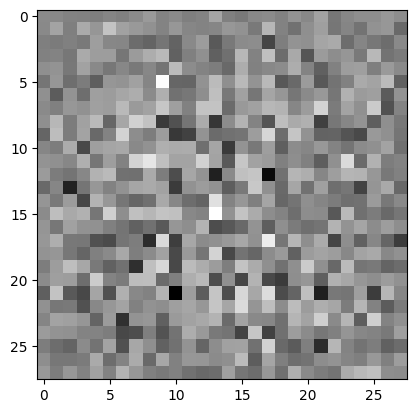

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

### Discriminator

The consistent use of $5\times 5$ kernels in the generator model provides a balance between computational efficiency and the ability to capture and generate detailed features.

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model



# def make_discriminator_model():
#   model = tf.keras.Sequential([
#       layers.Conv2D(64, (5,5),  strides = (2,2), padding = 'same', input_shape=[28, 28, 1]),
#       layers.LeakyReLU(),
#       layers.Dropout(0.3),

#       layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same'),
#       layers.LeakyReLU(),
#       layers.Dropout(0.3),

#       layers.Flatten(),
#       layers.Dense(1)
#   ])

#   return model

#### NOTE:
we have not added an activation layer in the output layer, as we will be using binary cross entropy which internally contains sigmoid activation function if we use from_logits = True

In [12]:
# using the untrained discriminator to predict whether an image is real or fake
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00011748]], shape=(1, 1), dtype=float32)


Note: the output above is called `Logit` as it is raw output from the model where no activation has been applied

## Loss and optimizer

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes.
- Fake 0 and real 1

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).

In [15]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### saving the checkpoints

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

### Defining the training loop

In [23]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
##### note: the decorator tf.function causes the function to get compiled

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

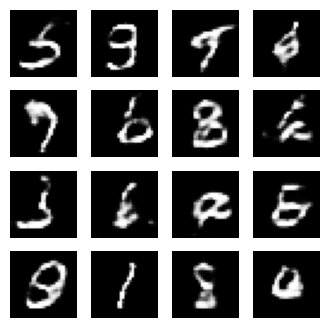

Time for epoch 57 is 11.355600595474243 sec


KeyboardInterrupt: 

In [24]:
train(train_dataset, EPOCHS)

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [26]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

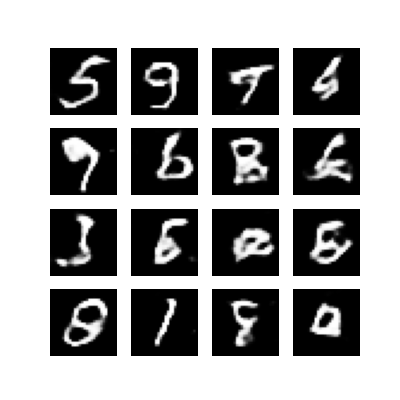

In [29]:
display_image(54) #display_image(EPOCHS)

In [28]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-28-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-28-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



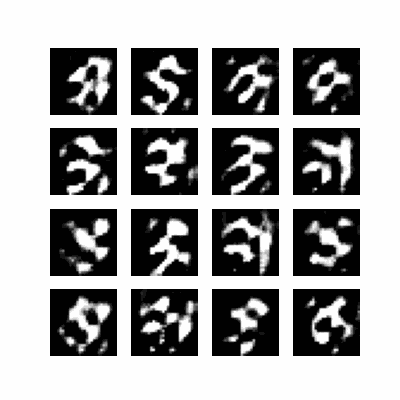

In [30]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)